Epoch 1/20
15/15 [==============================] - 7s 15ms/step - loss: 0.0908
Epoch 2/20
15/15 [==============================] - 0s 20ms/step - loss: 0.0129
Epoch 3/20
15/15 [==============================] - 0s 19ms/step - loss: 0.0079: 0s - loss: 0.00
Epoch 4/20
15/15 [==============================] - 0s 25ms/step - loss: 0.0075
Epoch 5/20
15/15 [==============================] - 0s 23ms/step - loss: 0.0064
Epoch 6/20
15/15 [==============================] - 0s 21ms/step - loss: 0.0062
Epoch 7/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0070
Epoch 8/20
15/15 [==============================] - 0s 27ms/step - loss: 0.0059
Epoch 9/20
15/15 [==============================] - 0s 26ms/step - loss: 0.0061
Epoch 10/20
15/15 [==============================] - 0s 23ms/step - loss: 0.0058
Epoch 11/20
15/15 [==============================] - 1s 34ms/step - loss: 0.0062
Epoch 12/20
15/15 [==============================] - 0s 22ms/step - loss: 0.0049
Epoch 13/20
15/15 [=

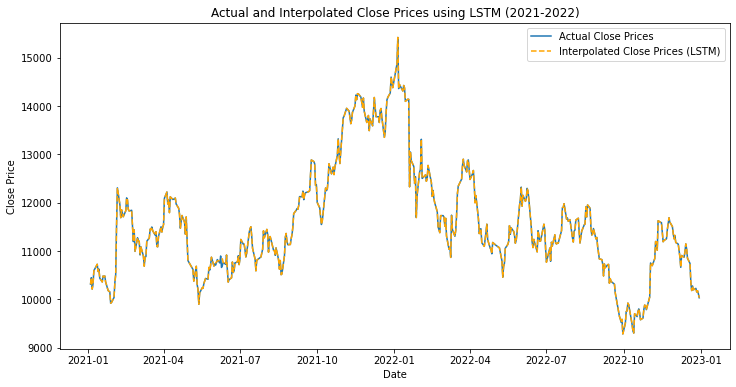

In [1]:
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# データの取得
df = pdr.DataReader("6758.JP", "stooq").sort_index()

# 日付範囲の選択（2021年1月1日から2022年12月31日まで）
df_selected = df[dt.datetime(2021,1,1):dt.datetime(2022,12,31)]

# 終値を使う
close_prices = df_selected["Close"]

# 内挿のために一部データを欠損値にする（例: 10日分のデータを欠損させる）
close_prices_interpolate = close_prices.copy()
close_prices_interpolate[dt.datetime(2021, 6, 1):dt.datetime(2021, 6, 10)] = np.nan

# データの正規化（LSTMの入力に適した形にスケーリング）
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices_interpolate.values.reshape(-1, 1))

# 訓練データの準備（欠損値を除外）
train_data = scaled_data[~np.isnan(scaled_data).flatten()]

# LSTMに渡すためのシーケンスデータを作成
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

seq_length = 10  # 過去10日のデータを使って次の日を予測
X_train, y_train = create_sequences(train_data, seq_length)

# データの形をLSTMが扱える形に変換
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# LSTMモデルの構築
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # 出力層

model.compile(optimizer='adam', loss='mean_squared_error')

# モデルの学習
model.fit(X_train, y_train, epochs=20, batch_size=32)

# 欠損部分の予測
missing_idx = np.where(np.isnan(scaled_data).flatten())[0]
for idx in missing_idx:
    input_sequence = scaled_data[idx-seq_length:idx, 0].reshape(1, seq_length, 1)
    predicted_value = model.predict(input_sequence)
    # predicted_valueは(1,1)の形状なので、[0, 0]で値を取り出し、スケール済みデータに代入
    scaled_data[idx, 0] = predicted_value[0, 0]

# スケールを元に戻す
interpolated_data = scaler.inverse_transform(scaled_data)

# 欠損部分を補完したデータを元に戻す
# interpolated_dataは(8, 1)の形なので、flatten()して(8,)に変換して代入
close_prices_interpolate.loc[close_prices_interpolate.isna()] = interpolated_data[missing_idx].flatten()

# 結果のプロット
plt.figure(figsize=(12,6))

# 実データと内挿データのプロット
plt.plot(close_prices.index, close_prices, label="Actual Close Prices")
plt.plot(close_prices_interpolate.index, close_prices_interpolate, label="Interpolated Close Prices (LSTM)", linestyle='--', color='orange')

plt.legend()
plt.title("Actual and Interpolated Close Prices using LSTM (2021-2022)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()
